In [56]:
import os
import torch
import librosa
import numpy as np
from torch.utils.data import Dataset, DataLoader

# Path to dataset
train_real_directory = r"C:/Users/shikh/OneDrive/Desktop/Audio Detection/dataset/for-2sec/for-2seconds/training/real"
train_fake_directory = r"C:/Users/shikh/OneDrive/Desktop/Audio Detection/dataset/for-2sec/for-2seconds/training/fake"

class AudioDataset(Dataset):
    def __init__(self, real_path, fake_path, target_length=16000, n_mfcc=20, fixed_time_steps=101):
        self.real_files = [os.path.join(real_path, f) for f in os.listdir(real_path) if f.endswith(".wav")]
        self.fake_files = [os.path.join(fake_path, f) for f in os.listdir(fake_path) if f.endswith(".wav")]
        self.files = [(file, 0) for file in self.real_files] + [(file, 1) for file in self.fake_files]  # 0 = real, 1 = fake
        self.target_length = target_length
        self.n_mfcc = n_mfcc
        self.fixed_time_steps = fixed_time_steps

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        audio_path, label = self.files[idx]
        
        # Load and fix audio length
        audio, sr = librosa.load(audio_path, sr=16000)
        audio = librosa.util.fix_length(audio, size=self.target_length)
        
        # Extract MFCC features
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=self.n_mfcc, n_fft=512, hop_length=160)
        
        # Pad or truncate to fixed time steps
        if mfcc.shape[1] < self.fixed_time_steps:
            mfcc = np.pad(mfcc, ((0, 0), (0, self.fixed_time_steps - mfcc.shape[1])))
        else:
            mfcc = mfcc[:, :self.fixed_time_steps]
        
        # Convert to tensor
        mfcc = torch.FloatTensor(mfcc)  # Shape: [n_mfcc, time_steps]
        label = torch.LongTensor([label])  # Ensure label is a tensor

        return mfcc, label


In [57]:
batch_size = 16

# Create dataset
train_dataset = AudioDataset(train_real_directory, train_fake_directory)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Check if dataset loads correctly
for mfcc, label in train_loader:
    print(f"MFCC Shape: {mfcc.shape}, Label: {label}")
    break


MFCC Shape: torch.Size([16, 20, 101]), Label: tensor([[1],
        [0],
        [0],
        [0],
        [1],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [0],
        [0],
        [1],
        [0],
        [1]])


In [58]:
import torch.nn as nn
import torch.optim as optim

class FakeAudioDetector(nn.Module):
    def __init__(self, n_mfcc=20, time_steps=101):
        super(FakeAudioDetector, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        
        # Calculate flattened size dynamically
        self.flattened_size = self._get_conv_output(n_mfcc, time_steps)
        
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, 2)  # Binary classification (real/fake)

    def _get_conv_output(self, n_mfcc, time_steps):
        dummy_input = torch.randn(1, 1, n_mfcc, time_steps)
        with torch.no_grad():
            x = self.pool(torch.relu(self.conv1(dummy_input)))
            x = self.pool(torch.relu(self.conv2(x)))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FakeAudioDetector().to(device)


In [59]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [60]:
epochs = 5  # Adjust as needed

for epoch in range(epochs):
    running_loss = 0.0
    model.train()

    for batch_idx, (mfcc, labels) in enumerate(train_loader):
        mfcc = mfcc.unsqueeze(1).to(device)  # Add channel dimension: [batch, 1, 20, 101]
        labels = labels.squeeze().to(device)  # Shape: [batch]

        # Forward pass
        outputs = model(mfcc)
        loss = criterion(outputs, labels)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if batch_idx % 10 == 9:  # Print every 10 batches
            print(f"Epoch {epoch+1}, Batch {batch_idx+1}, Loss: {running_loss/10:.4f}")
            running_loss = 0.0

print("🎉 Training Complete!")


Epoch 1, Batch 10, Loss: 16.2962
Epoch 1, Batch 20, Loss: 1.8498
Epoch 1, Batch 30, Loss: 0.7243
Epoch 1, Batch 40, Loss: 0.6616
Epoch 1, Batch 50, Loss: 0.6859
Epoch 1, Batch 60, Loss: 0.6801
Epoch 1, Batch 70, Loss: 0.6384
Epoch 1, Batch 80, Loss: 0.6312
Epoch 1, Batch 90, Loss: 0.6141
Epoch 1, Batch 100, Loss: 0.5657
Epoch 1, Batch 110, Loss: 0.5392
Epoch 1, Batch 120, Loss: 0.5409
Epoch 1, Batch 130, Loss: 0.5505
Epoch 1, Batch 140, Loss: 0.5065
Epoch 1, Batch 150, Loss: 0.5089
Epoch 1, Batch 160, Loss: 0.5110
Epoch 1, Batch 170, Loss: 0.4861
Epoch 1, Batch 180, Loss: 0.4351
Epoch 1, Batch 190, Loss: 0.3986
Epoch 1, Batch 200, Loss: 0.4729
Epoch 1, Batch 210, Loss: 0.4912
Epoch 1, Batch 220, Loss: 0.3621
Epoch 1, Batch 230, Loss: 0.3997
Epoch 1, Batch 240, Loss: 0.3741
Epoch 1, Batch 250, Loss: 0.4416
Epoch 1, Batch 260, Loss: 0.5786
Epoch 1, Batch 270, Loss: 0.4319
Epoch 1, Batch 280, Loss: 0.3737
Epoch 1, Batch 290, Loss: 0.3990
Epoch 1, Batch 300, Loss: 0.3740
Epoch 1, Batch 310

C:\Users\shikh\AppData\Local\Temp\ipykernel_25908\548255210.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(audio_path, sr=16000)
c:\Users\shikh\OneDrive\Desktop\Audio Detection\venv\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


Epoch 4, Batch 540, Loss: 0.0579
Epoch 4, Batch 550, Loss: 0.0458
Epoch 4, Batch 560, Loss: 0.1317
Epoch 4, Batch 570, Loss: 0.1848
Epoch 4, Batch 580, Loss: 0.0625
Epoch 4, Batch 590, Loss: 0.1447
Epoch 4, Batch 600, Loss: 0.0606
Epoch 4, Batch 610, Loss: 0.0629
Epoch 4, Batch 620, Loss: 0.0595
Epoch 4, Batch 630, Loss: 0.0520
Epoch 4, Batch 640, Loss: 0.0860
Epoch 4, Batch 650, Loss: 0.0491
Epoch 4, Batch 660, Loss: 0.0542
Epoch 4, Batch 670, Loss: 0.0698
Epoch 4, Batch 680, Loss: 0.0552
Epoch 4, Batch 690, Loss: 0.0581
Epoch 4, Batch 700, Loss: 0.1069
Epoch 4, Batch 710, Loss: 0.0893
Epoch 4, Batch 720, Loss: 0.0412
Epoch 4, Batch 730, Loss: 0.0596
Epoch 4, Batch 740, Loss: 0.0371
Epoch 4, Batch 750, Loss: 0.0886
Epoch 4, Batch 760, Loss: 0.0835
Epoch 4, Batch 770, Loss: 0.1087
Epoch 4, Batch 780, Loss: 0.0919
Epoch 4, Batch 790, Loss: 0.0346
Epoch 4, Batch 800, Loss: 0.0953
Epoch 4, Batch 810, Loss: 0.0974
Epoch 4, Batch 820, Loss: 0.0623
Epoch 4, Batch 830, Loss: 0.1387
Epoch 4, B

In [62]:
## Evaluation metrics
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mfcc, labels in train_loader:
        mfcc = mfcc.unsqueeze(1).to(device)
        labels = labels.squeeze().to(device)

        outputs = model(mfcc)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"📊 Model Accuracy: {accuracy:.2f}%")


📊 Model Accuracy: 98.95%


In [64]:
from torch.utils.data import DataLoader, Dataset
import os
import librosa
import torch
import numpy as np

# Paths for training and validation sets
train_real_directory = r"C:/Users/shikh/OneDrive/Desktop/Audio Detection/dataset/for-2sec/for-2seconds/training/real"
train_fake_directory = r"C:/Users/shikh/OneDrive/Desktop/Audio Detection/dataset/for-2sec/for-2seconds/training/fake"
validation_real_directory = r"C:/Users/shikh/OneDrive/Desktop/Audio Detection/dataset/for-2sec/for-2seconds/validation/real"
validation_fake_directory = r"C:/Users/shikh/OneDrive/Desktop/Audio Detection/dataset/for-2sec/for-2seconds/validation/fake"

# Define dataset class
class AudioDataset(Dataset):
    def __init__(self, real_dir, fake_dir, target_length=16000, n_mfcc=20, fixed_time_steps=101):
        self.files = []
        self.labels = []
        self.target_length = target_length
        self.n_mfcc = n_mfcc
        self.fixed_time_steps = fixed_time_steps

        # Load real audio
        for file in os.listdir(real_dir):
            if file.endswith(".wav"):
                self.files.append(os.path.join(real_dir, file))
                self.labels.append(0)  # 0 for real

        # Load fake audio
        for file in os.listdir(fake_dir):
            if file.endswith(".wav"):
                self.files.append(os.path.join(fake_dir, file))
                self.labels.append(1)  # 1 for fake

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        audio_path = self.files[idx]
        label = torch.LongTensor([self.labels[idx]])

        try:
            audio, sr = librosa.load(audio_path, sr=16000)
            audio = librosa.util.fix_length(audio, size=self.target_length)

            mfcc = librosa.feature.mfcc(
                y=audio, sr=sr, 
                n_mfcc=self.n_mfcc,
                n_fft=512,
                hop_length=160
            )

            # Pad or truncate
            if mfcc.shape[1] < self.fixed_time_steps:
                mfcc = np.pad(mfcc, ((0, 0), (0, self.fixed_time_steps - mfcc.shape[1])))
            else:
                mfcc = mfcc[:, :self.fixed_time_steps]

            mfcc_tensor = torch.FloatTensor(mfcc)  # Shape: [20, 101]

            return mfcc_tensor, label

        except Exception as e:
            print(f"❌ Error processing file: {audio_path}")
            print(f"⚠️ Exception: {e}")
            return None

# Create datasets
train_dataset = AudioDataset(train_real_directory, train_fake_directory)
validation_dataset = AudioDataset(validation_real_directory, validation_fake_directory)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=16, shuffle=False)

print("✅ Training & Validation Data Loaded Successfully!")


✅ Training & Validation Data Loaded Successfully!


In [65]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for mfcc, labels in validation_loader:  # Now validation_loader exists ✅
        mfcc = mfcc.unsqueeze(1).to(device)  # Add channel dimension
        labels = labels.squeeze().to(device)

        outputs = model(mfcc)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"📊 Validation Accuracy: {accuracy:.2f}%")  # Now this will work ✅


📊 Validation Accuracy: 96.36%


In [71]:
model_path = "C:/Users/shikh/OneDrive/Desktop/Audio Detection/audio_detection_model.pth"
torch.save(model.state_dict(), model_path)
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [74]:
torch.save(model.state_dict(), model_path)
print("✅ Model saved successfully!")




✅ Model saved successfully!


In [81]:
def predict_audio(audio_path, model, device):
    model.eval()
    try:
        audio, sr = librosa.load(audio_path, sr=16000)
        audio = librosa.util.fix_length(audio, size=16000)

        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=20, n_fft=512, hop_length=160)

        if mfcc.shape[1] < 101:
            mfcc = np.pad(mfcc, ((0, 0), (0, 101 - mfcc.shape[1])))
        else:
            mfcc = mfcc[:, :101]

        mfcc_tensor = torch.FloatTensor(mfcc).unsqueeze(0).unsqueeze(0).to(device)  # Add batch & channel

        with torch.no_grad():
            output = model(mfcc_tensor)
            _, predicted = torch.max(output, 1)

        return "Fake" if predicted.item() == 1 else "Real"

    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        return None

# 🔹 Example Usage:
audio_file = r"C:\Users\shikh\OneDrive\Desktop\Audio Detection\dataset\for-2sec\for-2seconds\testing\fake\file42.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav"
prediction = predict_audio(audio_file, model, device)
print(f"🧐 Prediction for {audio_file}: {prediction}")


🧐 Prediction for C:\Users\shikh\OneDrive\Desktop\Audio Detection\dataset\for-2sec\for-2seconds\testing\fake\file42.wav_16k.wav_norm.wav_mono.wav_silence.wav_2sec.wav: Fake


In [83]:
import os

save_dir = "saved_models"  # Directory where the model will be saved
os.makedirs(save_dir, exist_ok=True)  # ✅ Create folder if it doesn't exist

print(f"✅ Directory '{save_dir}' is ready!")


✅ Directory 'saved_models' is ready!


In [84]:
print(model)  # ✅ Check if the model is defined


FakeAudioDetector(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4000, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [85]:
import torch

save_path = "saved_models/audio_detection_model.pth"
torch.save(model.state_dict(), save_path)

print("✅ Model saved successfully at:", save_path)


✅ Model saved successfully at: saved_models/audio_detection_model.pth


In [87]:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report


In [88]:
# Ensure the model is in evaluation mode
model.eval()

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

with torch.no_grad():
    for mfcc, labels in validation_loader:  # Use the validation/test loader
        mfcc = mfcc.unsqueeze(1).to(device)  
        labels = labels.squeeze().to(device)  

        outputs = model(mfcc)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())  # Convert to NumPy array
        predicted_labels.extend(predicted.cpu().numpy())

# Convert to NumPy arrays for scikit-learn functions
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)


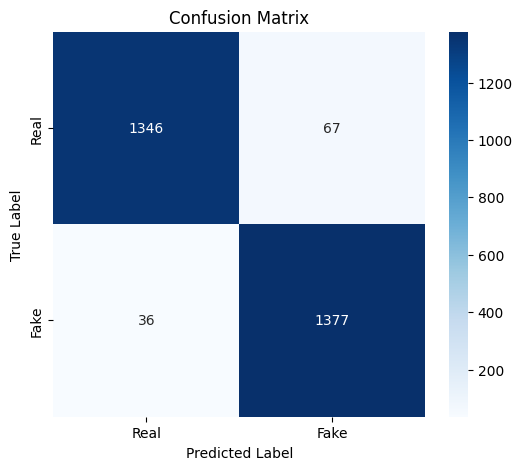

In [89]:
# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Define class labels (0 = Real, 1 = Fake)
class_labels = ["Real", "Fake"]

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# Generate classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))
